# DTEK0042 Exercise 3

*** Note for Google Colab Users ***
     Because Google Colab doesn't have a button to convert your notebook to .html format here is a quick work around:
   1. open a new google colab notebook
   2. in the files section in google colab, upload the .ipynb file you want to be converted to .html
   3. in your new open notebook run this command in an empty cell: !jupyter nbconvert --to html YourFileName.ipynb
   4. after the command is finished running refresh the page
   5. In your files section you should see your original .ipynb file that you uploaded and then a .html file of that same notebook.
   6. download the .html file and you're good to go!

In this exercise, you are required to analyze a PPG signal step-by-step as outlined below.  The deliverables for this exercise are a jupyter notebook and a .html file exported form the notebook. The notebook should includes your code, observations, graphs, and conclusions made upon analyzing the given PPG signal. Please provide caption and description for every figure. 

## 1- library Imports

In [206]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# 2- Data Import and plotting
* Import the PPG signal data “PPG_record.txt” into your python environment and store it in a variable named “PPG_data”.
* The first column contains timestamp of samples, the second one contains red, the third one contains infrared (IR), and the last column contains green sensor data. 
* Take IR signal and store it in a variable called “PPG_sig”.  
* Note: the sampling frequency of this signal is 132 Hz. 
* Plot the IR signal stored in "PPG_sig" VS Time in seconds
* When plotting the data "PPG_sig" vs time in seconds, use the function np.linspace to make a seconds array using the length of "PPG_sig" and the sampling frequency of 132 Hz. Do not use the timestamp column of the data.

     HINT: 
         PPG_data = np.loadtxt(the directory of the PPG Data) 
         
         or
         
         PPG_data = pd.read_csv(the directory of the PPG Data, names = [name for each column])
         * Note: If you are using pandas to load into data, we'd recommend you convert pandas series data to numpy type for further analysis

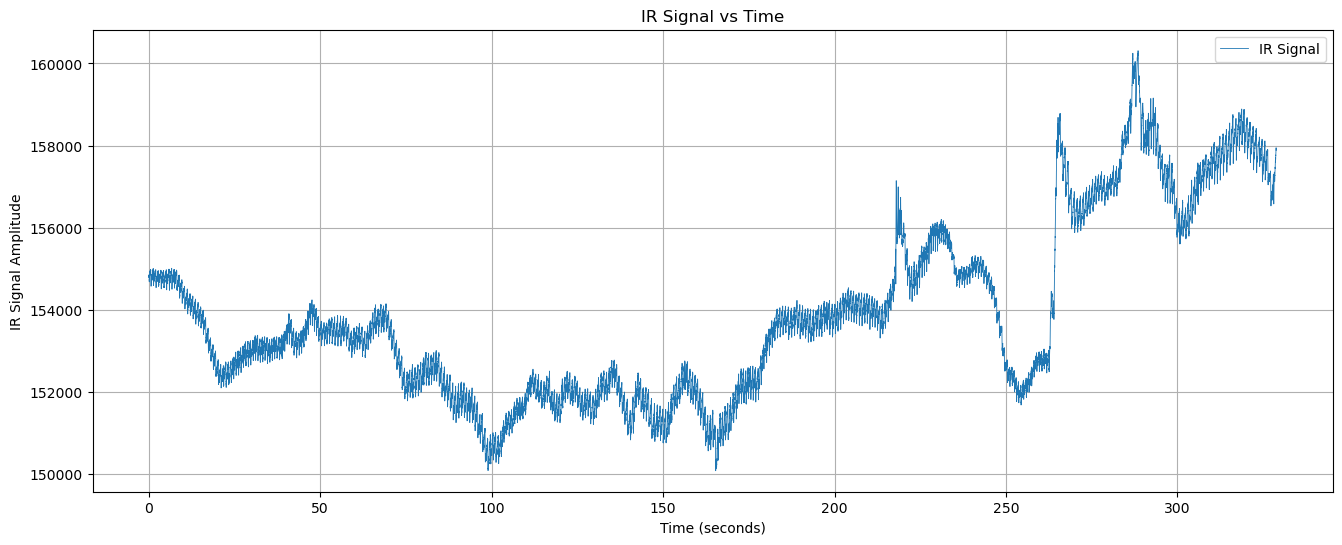

In [416]:
#code
PPG_data = np.loadtxt('PPG_record.txt', delimiter=',')

PPG_sig = PPG_data[:, 2] 

sampling_frequency = 132 

time_seconds = np.linspace(0, len(PPG_sig) / sampling_frequency, len(PPG_sig))

plt.figure(figsize=(16, 6))
plt.plot(time_seconds, PPG_sig, linewidth=.6, label="IR Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("IR Signal Amplitude")
plt.title("IR Signal vs Time")
plt.grid(True)
plt.legend()
plt.show()

# 3- Compute power spectral density (PSD)

 * Compute power spectral density (PSD) using the Welch method provided by scipy package.  Select only the frequencies between 0.7 and 3Hz since the human heart rate typically does not go beyond these limits. 
 * Plot the limited PSD versus frequency
 * Find the dominant PSD value and its corresponding frequency. 
 * Store the value of the found frequency component in a variable named “dominant_freq”. 
 * Reference:
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch
 
      
      HINT: 
        PSD_freqs , PSD = scipy.signal.welch() 
        Set the nperseg parameter to be = 10*Fs
        

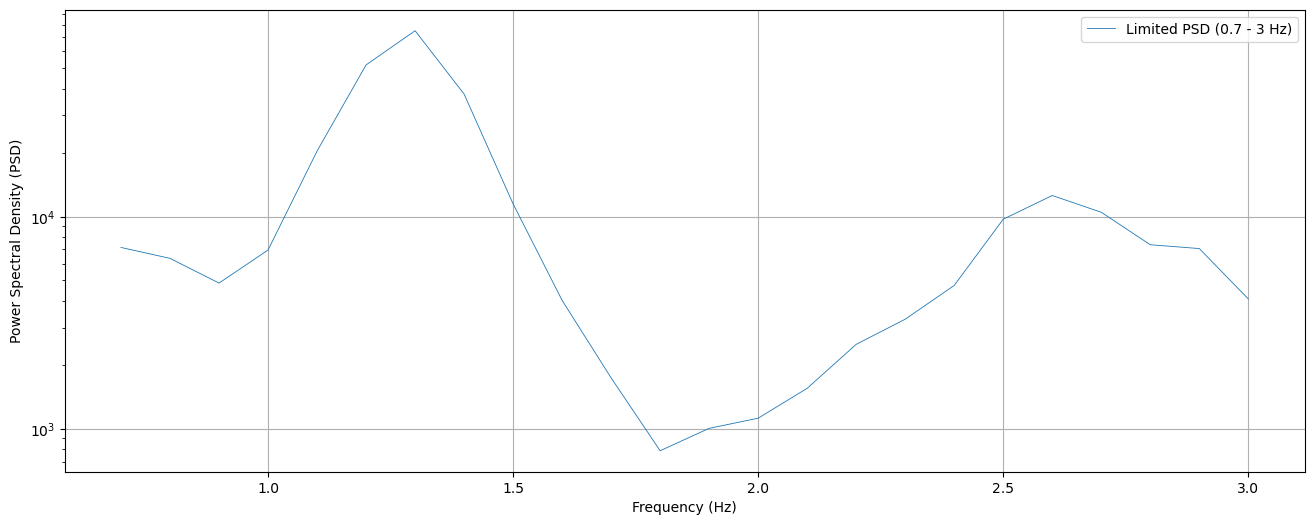

Dominant frequency: 1.3 Hz
Dominant PSD value: 75103.19231029775


In [418]:
# code
sampling_frequency = 132

frequencies, PSD = signal.welch(PPG_sig, fs=sampling_frequency, nperseg=10*sampling_frequency)

freq_range_mask = (frequencies >= 0.7) & (frequencies <= 3)
limited_frequencies = frequencies[freq_range_mask]
limited_PSD = PSD[freq_range_mask]

plt.figure(figsize=(16, 6))
plt.semilogy(limited_frequencies, limited_PSD, linewidth=.6, label="Limited PSD (0.7 - 3 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (PSD)")
plt.grid(True)
plt.legend()
plt.show()

dominant_freq_index = np.argmax(limited_PSD)
dominant_freq = limited_frequencies[dominant_freq_index]
dominant_PSD_value = limited_PSD[dominant_freq_index]

print(f"Dominant frequency: {dominant_freq} Hz")
print(f"Dominant PSD value: {dominant_PSD_value}")

# 4- Band Pass Filter Design and Filtering of PPG signal
*  Design a band pass filter. Use Butterworth filter of order 4 with cutoff frequencies equal to (dominant_freq – 0.3) and (dominant_freq + 0.3).

* Filter the original PPG signal with the designed filter. 

* Plot the filtered PPG signal showing heartbeats in the form of a sinusoid


* Note: the documentation of scipy package online is very comprehensive and informative. there are examples that 
  you can easily follow and use to solve the given exercise here. 
  https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html    
    
   
      HINT: 
        from scipy.signal import butter, filtfilt, freqz
    

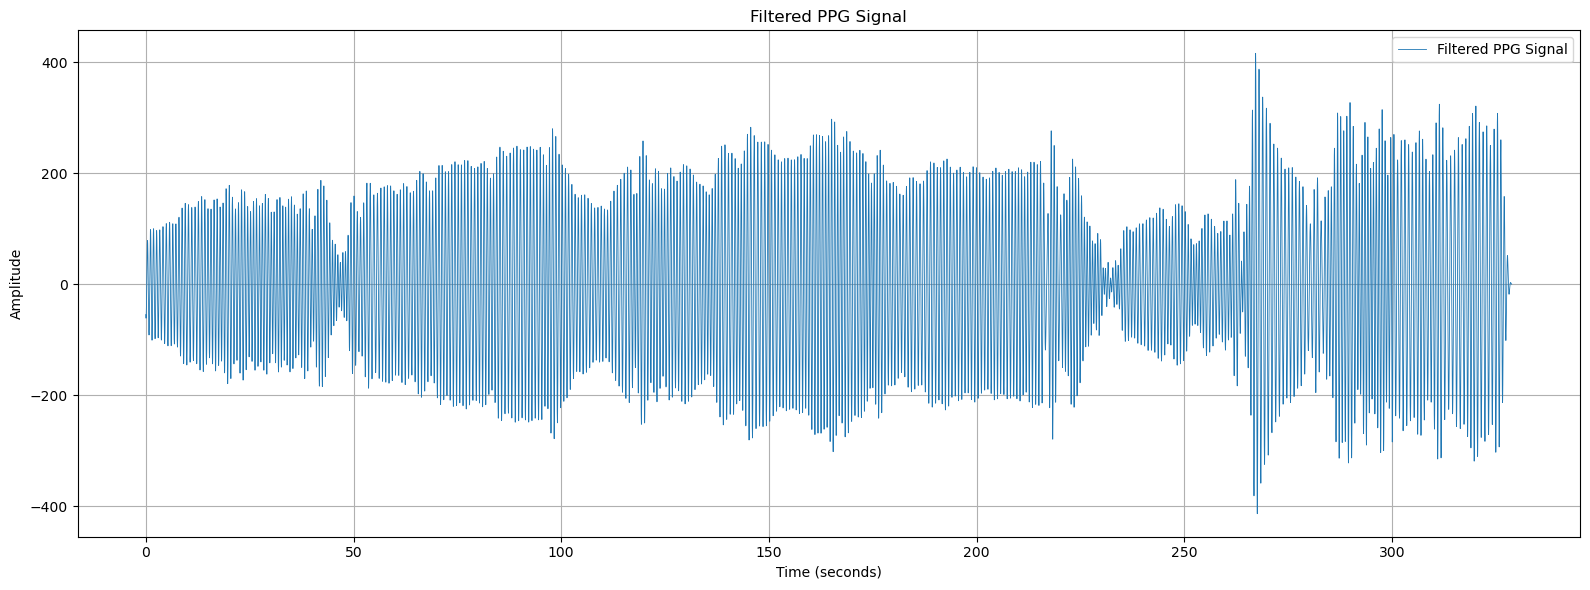

In [411]:
# code
from scipy.signal import butter, filtfilt, freqz, find_peaks

low_cutoff = dominant_freq - 0.3
high_cutoff = dominant_freq + 0.3

order = 4
nyquist = 0.5 * sampling_frequency
low = low_cutoff / nyquist 
high = high_cutoff / nyquist 

b, a = butter(order, [low, high], btype='band')

filtered_PPG_sig = filtfilt(b, a, PPG_sig)

time = np.linspace(0, len(filtered_PPG_sig) / sampling_frequency, len(filtered_PPG_sig))
plt.figure(figsize=(16, 6))

plt.plot(time, filtered_PPG_sig, linewidth=.6, label="Filtered PPG Signal")
plt.title("Filtered PPG Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## Observations:
    The filtered signal shows a smooth, wave like pattern that captures the steady rhythm of heartbeats. The filter effectively removed unwanted noise, separating the main heart rate frequencies within the desired range. As a result, the filtered signal shows clear peaks that match each heartbeat, making it easier to identify RR intervals and calculate heart rate. This means the filter kept the important heart rate information while removing noise from the original signal.

# 5- Find the maximum extrema points (or peaks) of the signal
* The distance between every two consecutive peak location correlates with the RR interval.
* Find the peaks of the filtered signal in the time domain.
* Calculate these peak-to-peak intervals, store it in a variable named “RR_intervals” and report the average value of these intervals. 
* Convert the computed average value to heart rate as shown below and report it
* You can use “argrelextrema” function in scipy package for peak detection
* Plot Filtered PPG With peak locations
* Describe your observations below
* Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html

      HINT:
        from scipy.signal import argrelextrema
        HeartRate = 60.0/avg_peak_intervals 

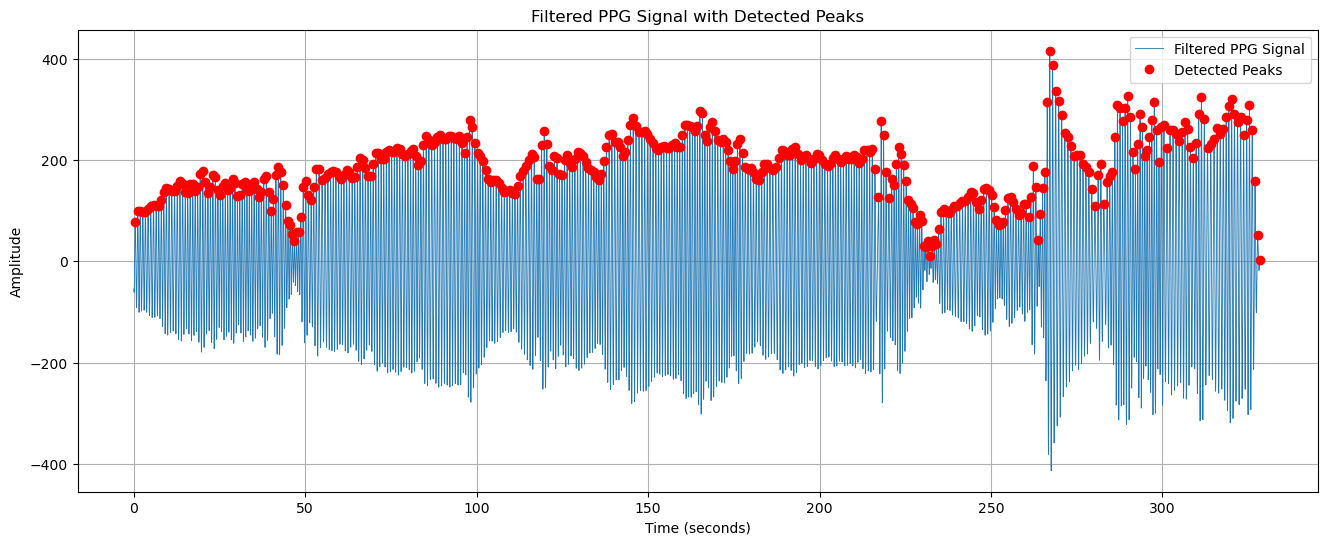

Average RR Interval: 0.7649 seconds
Heart Rate: 78.45 BPM


In [422]:
#code
from scipy.signal import argrelextrema

peaks_indices = argrelextrema(filtered_PPG_sig, np.greater)[0]
peak_values = filtered_PPG_sig[peaks_indices]
peak_times = time[peaks_indices]

RR_intervals = np.diff(peak_times)

avg_RR_interval = np.mean(RR_intervals)

heart_rate = 60.0 / avg_RR_interval

plt.figure(figsize=(16, 6))
plt.plot(time_array, filtered_PPG_sig, linewidth=.6, label="Filtered PPG Signal")
plt.plot(peak_times, peak_values, 'ro', label="Detected Peaks")
plt.title("Filtered PPG Signal with Detected Peaks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

# Output the results
print(f"Average RR Interval: {avg_RR_interval:.4f} seconds")
print(f"Heart Rate: {heart_rate:.2f} BPM")

## Observations: 
    The above code block shows the calculation of distance between RR intervals. This average RR interval is then used to calculate the heart rate in BPM by dividing 60 by the average RR interval. The filtered PPG signal is then plotted with the detected peaks marked as red dots, providing a clear visual representation of the heartbeats. It also confirms the accuracy of the peak detection, showing the smooth, filtered signal with well-defined peaks.

# 6- Calculate SDNN and RMSSD
* AVNN is average of the time interval between successive normal heart beats. 
* SDNN is standard deviation of the time interval between successive normal heart beats (i.e. the RR-intervals).
* RMSSD is the Root mean square of successive RR interval differences.

* Calculate AVNN, SDNN and RMSSD from the “RR_intervals” variable. 
* These are heart rate variability parameters. Report the AVNN, SDNN and RMSSD values. 
* RMSSD formula can be found in https://www.biopac.com/application/ecg-cardiology/advanced-feature/rmssd-for-hrv-analysis/

* Note: Time unit for intervals should be in millisecond.
   
   HINT:
        Use np.diff(RR_intervals) to calculate the difference between successive rr intervals
        Use np.std() for SDNN
        

In [387]:
#code
RR_intervals_ms = RR_intervals * 1000  

AVNN = np.mean(RR_intervals_ms)

SDNN = np.std(RR_intervals_ms)

RR_diff = np.diff(RR_intervals_ms)  
RMSSD = np.sqrt(np.mean(RR_diff**2))

print(f"AVNN: {AVNN:.2f} ms")
print(f"SDNN: {SDNN:.2f} ms")
print(f"RMSSD: {RMSSD:.2f} ms")

AVNN: 764.85 ms
SDNN: 64.59 ms
RMSSD: 34.36 ms


## Observations:
    These calculations represent the heart's activity. An AVNN of 764.85 ms indicates an average heart rate of approximately 78.5 bpm, representing a normal resting heart rate. The SDNN value of 64.59 ms suggests moderate variability in the RR intervals, which is generally associated with a healthy heart and autonomic flexibility. The RMSSD of 34.36 ms, a measure of short-term variability, is within a normal range. All these values suggest a balanced and healthy cardiovascular system.